<center>

# **Pioneer V1 Model Architecture**

</center>


## **Model Architecture**

In [4]:
import torch.nn as nn
import torch.nn.functional as F

from torch import optim

In [5]:
class Pioneer(nn.Module):
    def __init__(self):
        super(Pioneer, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=64*5*5, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        # Convolutional layers with max pooling
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        
        # Flatten the output for fully connected layers
        x = x.view(-1, 64*5*5)
        
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [6]:
pioneer_v1 = Pioneer()

print(f"Model Architecture: \n\n{pioneer_v1}")

Model Architecture: 

Pioneer(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## **MNIST Dataset**

In [7]:
import torch

from matplotlib import pyplot as plt

from torchvision import datasets, transforms

In [8]:
# Transform MNIST Dataset To Pytorch Friendly Format
transform = transforms.Compose(
                                [transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,)),]
                               )

In [9]:
# Training Set
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

# Evaluation Set
mnist_evalset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
eval_loader = torch.utils.data.DataLoader(mnist_evalset, batch_size=10, shuffle=True)

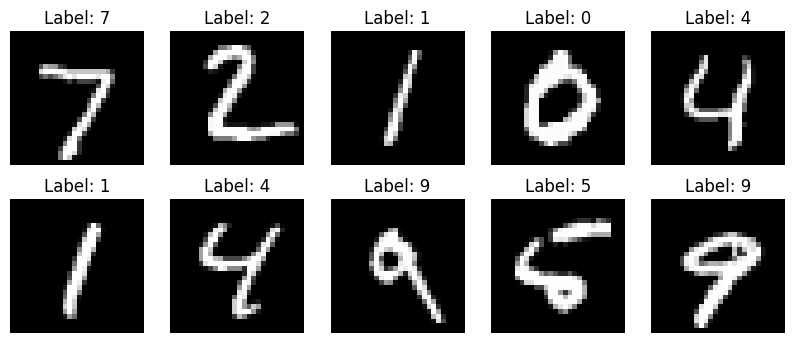

In [12]:
# Plot Evaluation Set
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    tensor, label = mnist_evalset[i]
    ax.imshow(tensor.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

## **MNIST Training**

In [13]:
class PioneerTrainer:
    def __init__(self, model, train_loader, eval_loader, criterion, optimizer, checkpoint_path):
        self.model = model
        self.train_loader = train_loader
        self.eval_loader = eval_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.checkpoint_path = checkpoint_path

    def train(self, epochs=5):
        print("Training started...")
        for epoch in range(1, epochs + 1):
            running_loss = 0.0
            for i, (inputs, labels) in enumerate(self.train_loader, 1):
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

                if i % 100 == 0:
                    print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(self.train_loader)}], Loss: {running_loss / i:.4f}")

            print(f"Epoch [{epoch}/{epochs}], Loss: {running_loss / len(self.train_loader):.4f}")

            # Save checkpoint
            self.save_checkpoint(epoch)

        print("Training finished.")

    def evaluate(self):
        print("Evaluation started...")
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.eval_loader:
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Accuracy of the network on the {total} test images: {accuracy:.2f}%")
        print("Evaluation finished.")

    def save_checkpoint(self, epoch):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': self.criterion
        }
        torch.save(checkpoint, self.checkpoint_path)
        print("Checkpoint saved.")

In [ ]:
# Initialize your model, criterion, optimizer, and data loaders
pioneer_v1 = Pioneer()
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=128, shuffle=True)
mnist_evalset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
eval_loader = torch.utils.data.DataLoader(mnist_evalset, batch_size=128, shuffle=False)
criterion = nn.NLLLoss()
optimizer = optim.SGD(pioneer_v1.parameters(), lr=0.01, momentum=0.5)

# Create the trainer instance
trainer = PioneerTrainer(pioneer_v1, train_loader, eval_loader, criterion, optimizer, checkpoint_path='pioneer_checkpoint.pth')

# Train the model
trainer.train(epochs=5)

# Evaluate the model
trainer.evaluate()

## **Further Train Model**

In [14]:
# Initialize your model, criterion, optimizer, and data loaders
pioneer_v2 = Pioneer()

# Load the checkpoint
checkpoint = torch.load('pioneer_checkpoint_v2.pth')

# Load model state
pioneer_v2.load_state_dict(checkpoint['model_state_dict'])

# Initialize the optimizer
optimizer = optim.SGD(pioneer_v2.parameters(), lr=0.01, momentum=0.5)

# Load optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Modify optimizer parameters
optimizer.param_groups[0]['lr'] = 0.005  
optimizer.param_groups[0]['momentum'] = 0.9  

# Initialize the data loaders, criterion, and transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=128, shuffle=True)
mnist_evalset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
eval_loader = torch.utils.data.DataLoader(mnist_evalset, batch_size=128, shuffle=False)
criterion = nn.NLLLoss()

# Create the trainer instance
trainer = PioneerTrainer(pioneer_v2, train_loader, eval_loader, criterion, optimizer, checkpoint_path='pioneer_checkpoint_v2.pth')

# Train the model
trainer.train(epochs=10)

# Evaluate the model
trainer.evaluate()

Training started...
Epoch [1/10], Step [100/469], Loss: 0.0070
Epoch [1/10], Step [200/469], Loss: 0.0072
Epoch [1/10], Step [300/469], Loss: 0.0071
Epoch [1/10], Step [400/469], Loss: 0.0069
Epoch [1/10], Loss: 0.0070
Checkpoint saved.
Epoch [2/10], Step [100/469], Loss: 0.0051
Epoch [2/10], Step [200/469], Loss: 0.0058
Epoch [2/10], Step [300/469], Loss: 0.0066
Epoch [2/10], Step [400/469], Loss: 0.0068
Epoch [2/10], Loss: 0.0069
Checkpoint saved.
Epoch [3/10], Step [100/469], Loss: 0.0063
Epoch [3/10], Step [200/469], Loss: 0.0052
Epoch [3/10], Step [300/469], Loss: 0.0056
Epoch [3/10], Step [400/469], Loss: 0.0060
Epoch [3/10], Loss: 0.0061
Checkpoint saved.
Epoch [4/10], Step [100/469], Loss: 0.0056
Epoch [4/10], Step [200/469], Loss: 0.0057
Epoch [4/10], Step [300/469], Loss: 0.0057
Epoch [4/10], Step [400/469], Loss: 0.0057
Epoch [4/10], Loss: 0.0059
Checkpoint saved.
Epoch [5/10], Step [100/469], Loss: 0.0058
Epoch [5/10], Step [200/469], Loss: 0.0052
Epoch [5/10], Step [300/46

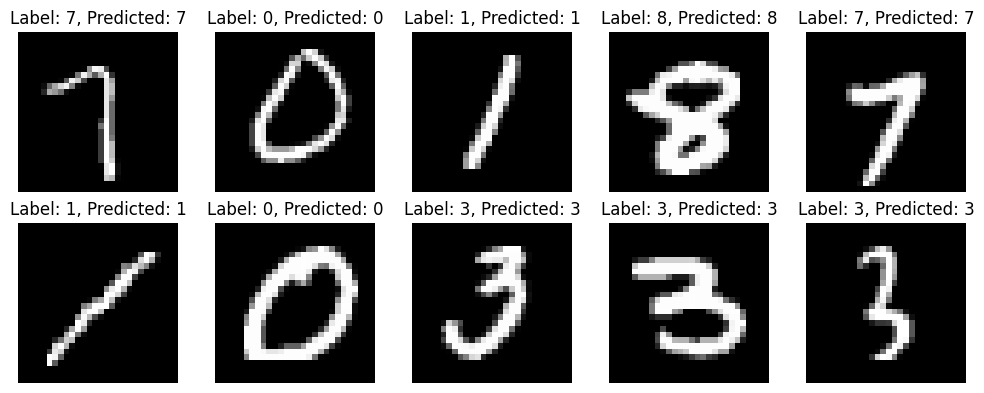

In [15]:
import torch
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

# Load the checkpoint
checkpoint = torch.load('pioneer_checkpoint_v2.pth')

# Initialize the model and load its state
pioneer_v2 = Pioneer()
pioneer_v2.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
pioneer_v2.eval()

# Load the MNIST evaluation dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])
mnist_evalset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
eval_loader = torch.utils.data.DataLoader(mnist_evalset, batch_size=10, shuffle=True)

# Function to plot images
def plot_images(images, labels, predicted_labels):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].numpy().squeeze(), cmap='gray')
        ax.set_title(f"Label: {labels[i]}, Predicted: {predicted_labels[i]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Function to make predictions on a batch of images
def predict_batch(model, images):
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    return predicted

# Get a batch of sample images and labels
images, labels = next(iter(eval_loader))

# Make predictions
predicted_labels = predict_batch(pioneer_v2, images)

# Plot the images with predicted labels
plot_images(images, labels, predicted_labels)